<a href="https://colab.research.google.com/github/MohamadHBaydoun/COMP9444/blob/MohamadBranch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MohamadHBaydoun/COMP9444.git

Cloning into 'COMP9444'...
remote: Enumerating objects: 3463, done.
remote: Total 3463 (delta 0), reused 0 (delta 0), pack-reused 3463 (from 1)
Receiving objects: 100% (3463/3463), 2.47 GiB | 41.62 MiB/s, done.
Resolving deltas: 100% (399/399), done.
Updating files: 100% (3835/3835), done.


In [12]:
# 0. Import packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
import torch.nn.functional as F

In [3]:
# 1. Create model


# USE RESIDUAL NEURAL NETWORKS AND FCN'S WITH 1X1 CONVOLUTIONS AND UPSAMPLING OPERATIONS
import torch

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6):
        super(UNet, self).__init__()

        # Downsampling (Encoder)
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv3 = self.double_conv(128, 256)

        # Upsampling (Decoder)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = self.double_conv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = self.double_conv(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x3 = self.conv2(x2)
        x4 = self.pool2(x3)

        # Bottleneck
        x5 = self.conv3(x4)

        # Decoder with skip connections
        x6 = self.up1(x5)
        x6 = torch.cat([x3, x6], dim=1)
        x7 = self.conv4(x6)

        x8 = self.up2(x7)
        x8 = torch.cat([x1, x8], dim=1)
        x9 = self.conv5(x8)

        return self.final_conv(x9)

# Create model instance
model = UNet(in_channels=3, out_channels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Sequential(
    (0): Conv2d(256, 128

In [10]:
# 2. Prepare data
IMAGE_PATH = "./COMP9444/filtered_image"
LABEL_PATH = "./COMP9444/filtered_label"

trainFiles = pd.read_csv("./COMP9444/train.csv", header=None)[0].tolist()[:250]
testFiles = pd.read_csv("./COMP9444/test.csv", header=None)[0].tolist()[:250]


def load_image(path):
    """Load an RGB image and convert to a tensor"""
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((540, 960)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(img)  # Apply transform

class QuakeCityDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img = load_image(os.path.join(IMAGE_PATH, filename))
        # component = load_annotation("component", filename)
        crack = load_image(os.path.join(LABEL_PATH, "crack", filename))
        # spall = load_annotation("spall", filename)
        # rebar = load_annotation("rebar", filename)
        # ds = load_annotation("ds", filename)
        # depth = load_annotation("depth", filename)
        label = crack
        return img, label

# Create dataset and dataloader
train_dataset = QuakeCityDataset(trainFiles)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

# Get a batch
img_batch, label_batch = next(iter(train_loader))
print("Batch image shape:", img_batch.shape)
print("Batch label shape:", label_batch.shape)


Batch image shape: torch.Size([5, 3, 540, 960])
Batch label shape: torch.Size([5, 3, 540, 960])


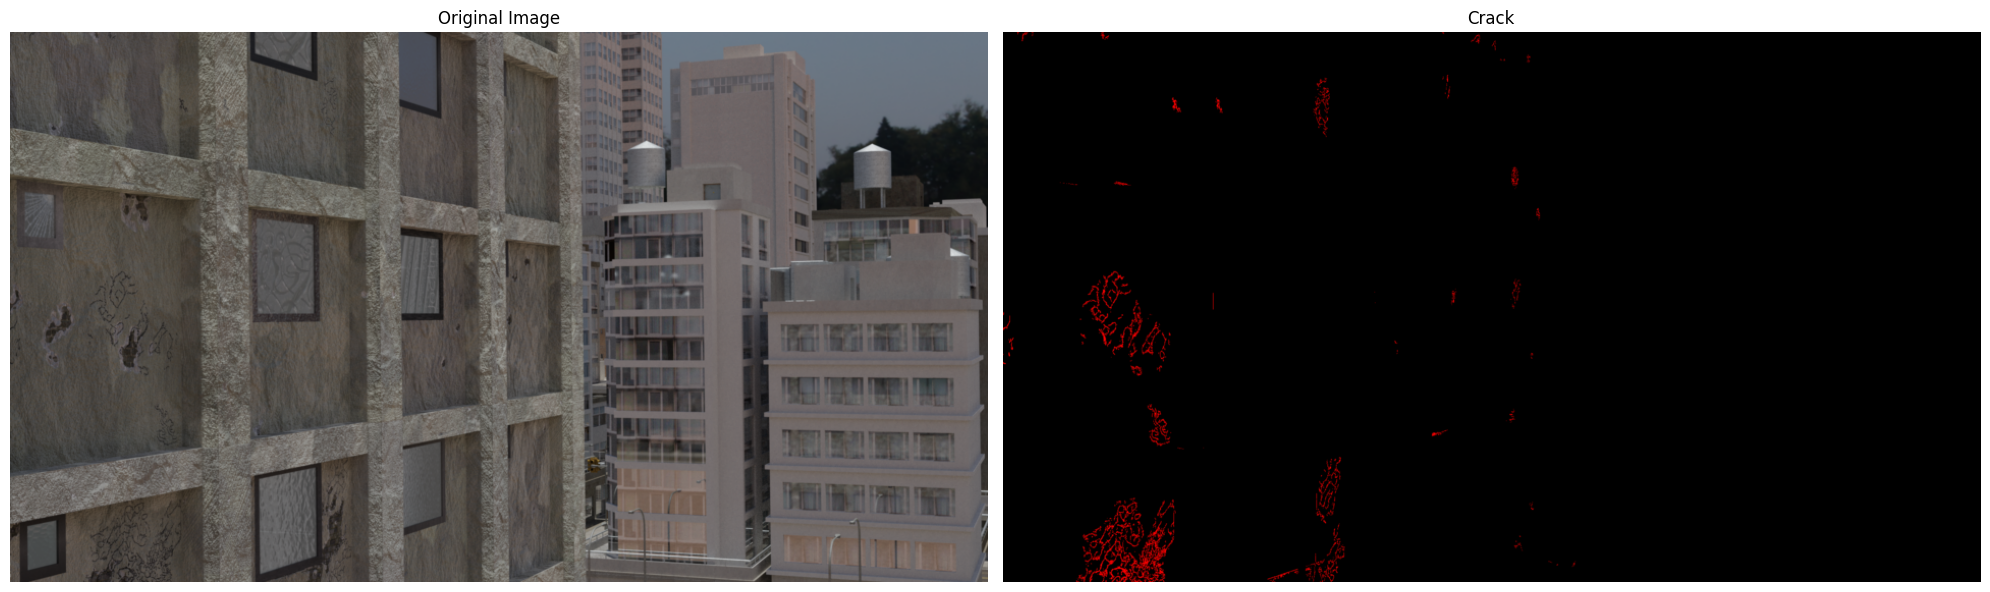

In [5]:
# 2.5 Visualise data
def visualize_sample(image, label):
    """Display the image and its 6 label masks."""
    label_names = ["Component", "Crack", "Spall", "Rebar", "Damage State", "Depth"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Show the original image
    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    # Show the label mask
    axes[1].imshow(label.permute(1, 2, 0))  # Visualize label
    axes[1].set_title(label_names[1])
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

img_batch, label_batch = next(iter(train_loader))
visualize_sample(img_batch[0], label_batch[0])

In [6]:
# 3. Choose optimizer

criterion = nn.CrossEntropyLoss()  # Multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import gc
gc.collect()

66

In [14]:
epochs = 2

for epoch in range(1, epochs):
    for batch_id, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        print('Epoch%3d: zero_grad(): loss=%7.4f output_mean=%7.4f target_mean=%7.4f' %
              (epoch, loss.item(), output.mean().item(), target.mean().item()))

        # Get the last image in the batch
        original_img = data[-1].cpu()
        prediction = output[-1].cpu().detach()

        # Convert original image back to (H, W, C) format for display
        original_img_np = TF.to_pil_image(original_img)
        original_img_np = np.array(original_img_np)

        # Convert prediction to a grayscale heatmap (e.g., red for cracks)
        prediction_np = prediction.numpy().mean(0)  # Collapse channel dimension
        prediction_np = (prediction_np - prediction_np.min()) / (prediction_np.max() - prediction_np.min())
        prediction_np = np.uint8(255 * prediction_np)

        # Create heatmap using OpenCV
        heatmap = cv2.applyColorMap(prediction_np, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay the heatmap on the original image
        overlay = cv2.addWeighted(original_img_np, 0.6, heatmap, 0.4, 0)

        # Display
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_img_np)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Predicted Heatmap")
        plt.imshow(heatmap)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(overlay)
        plt.axis("off")

        plt.tight_layout()
        plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 634.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 202.12 MiB is free. Process 29475 has 14.54 GiB memory in use. Of the allocated memory 14.03 GiB is allocated by PyTorch, and 397.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)